In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter

import tonic
import tonic.transforms as transforms

In [3]:
DATA_DIR = "./newdata"  # where you downloaded DVSGesture

In [4]:
# Helper: ensure sensor_size is (H, W, C) with C=2 (ON/OFF)
def ensure_3d_sensor_size(sensor_size):
    if len(sensor_size) == 2:
        return (sensor_size[0], sensor_size[1], 2)
    return tuple(sensor_size)

SENSOR_SIZE = ensure_3d_sensor_size(tuple(tonic.datasets.DVSGesture.sensor_size))
H, W, C = SENSOR_SIZE
print("Sensor size:", SENSOR_SIZE)  # should be (128, 128, 2)

# Load TEST split with **no transform** (we’ll transform on-the-fly)
test_ds = tonic.datasets.DVSGesture(save_to=DATA_DIR, train=False)
print("Test samples:", len(test_ds))

# Class names if present
class_names = getattr(test_ds, "classes", None)
if class_names is None:
    class_names = [str(i) for i in range(11)]  # fallback
print("Class names:", class_names)

Sensor size: (128, 128, 2)


691456000it [01:05, 10637456.32it/s]                               


Extracting ./newdata\DVSGesture\ibmGestureTest.tar.gz to ./newdata\DVSGesture
Test samples: 264
Class names: ['Hand clapping', 'Right hand wave', 'Left hand wave', 'Right arm cw', 'Right arm ccw', 'Left arm cw', 'Left arm ccw', 'Arm roll', 'Air drums', 'Air guitar', 'Other gestures']


In [5]:
# Choose number of frames per sample for viewing
N_FRAMES = 60

toframe = transforms.ToFrame(
    sensor_size=SENSOR_SIZE,
    n_time_bins=N_FRAMES
)

def events_to_frames(event_stream):
    """
    Returns frames of shape (T, 2, H, W), int counts.
    """
    frames = toframe(event_stream)  # numpy array
    return frames

def make_color_overlay(frame_2ch):
    """
    Convert one frame (2, H, W) to RGB (H, W, 3):
    OFF (channel 0) -> Red, ON (channel 1) -> Blue.
    Each channel normalized to [0,1] independently.
    """
    off = frame_2ch[0].astype(np.float32)
    on  = frame_2ch[1].astype(np.float32)

    def norm(a):
        rng = a.max() - a.min()
        return (a - a.min()) / (rng + 1e-6)
    off_n = norm(off)
    on_n  = norm(on)

    rgb = np.zeros((frame_2ch.shape[1], frame_2ch.shape[2], 3), dtype=np.float32)
    rgb[..., 0] = off_n  # Red
    rgb[..., 2] = on_n   # Blue
    return rgb

Sample 0 | Label=0 (Hand clapping) | frames=60 | duration≈4569.0 ms


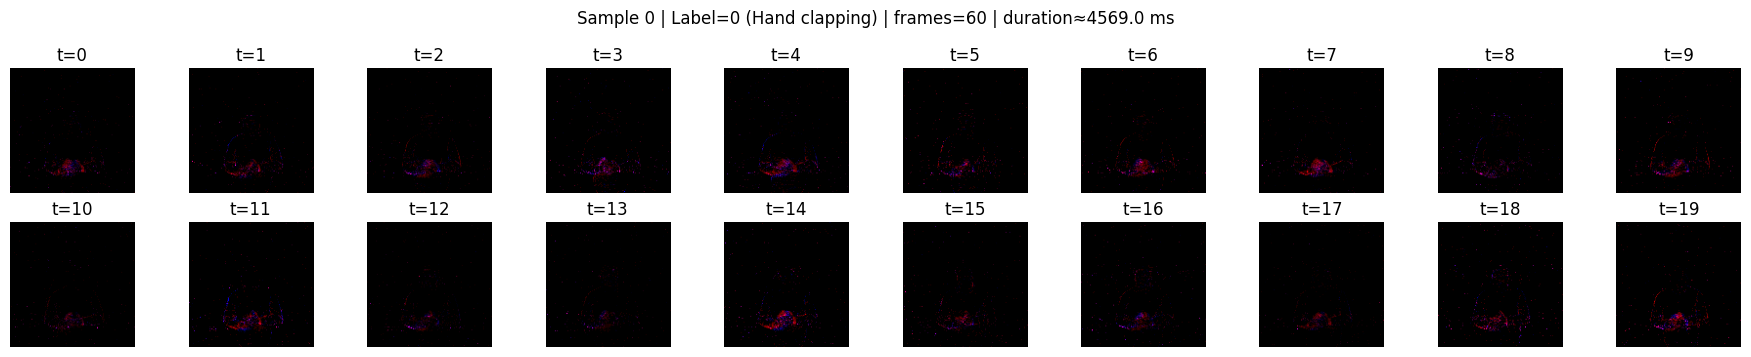

Sample 1 | Label=1 (Right hand wave) | frames=60 | duration≈5995.7 ms


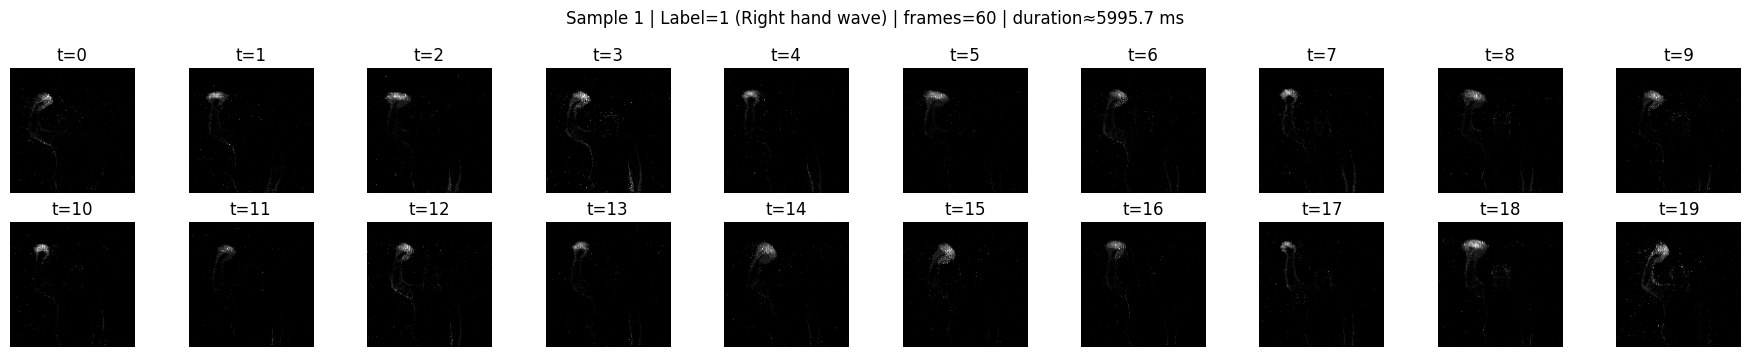

In [6]:
def preview_sample(idx, mode="overlay", num_cols=10):
    """
    mode: "overlay" (R=OFF, B=ON) or "sum" (grayscale ON+OFF)
    """
    ev, label = test_ds[idx]
    frames = events_to_frames(ev)  # (T, 2, H, W)
    T = frames.shape[0]
    num_show = min(20, T)
    num_rows = int(np.ceil(num_show / num_cols))

    # Info about the raw event stream
    t_min = ev['t'].min() if len(ev) > 0 else 0
    t_max = ev['t'].max() if len(ev) > 0 else 0
    duration_ms = (t_max - t_min) / 1000.0

    title = f"Sample {idx} | Label={label} ({class_names[label]}) | frames={T} | duration≈{duration_ms:.1f} ms"
    print(title)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.8*num_cols, 1.8*num_rows))
    if num_rows == 1 and num_cols == 1:
        axes = np.array([[axes]])
    elif num_rows == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_rows * num_cols):
        ax = axes[i // num_cols, i % num_cols]
        ax.axis("off")
        if i < num_show:
            f = frames[i]  # (2, H, W)
            if mode == "overlay":
                img = make_color_overlay(f)  # (H, W, 3)
                ax.imshow(img)
            else:  # "sum"
                ax.imshow(f.sum(axis=0), cmap='gray')
            ax.set_title(f"t={i}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Try a few random test samples
preview_sample(0, mode="overlay")
preview_sample(1, mode="sum")

In [7]:
def animate_sample(idx, mode="overlay", save_gif=True, out_dir="./gifs"):
    os.makedirs(out_dir, exist_ok=True)
    ev, label = test_ds[idx]
    frames = events_to_frames(ev)
    T = frames.shape[0]

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.axis("off")
    if mode == "overlay":
        first_img = make_color_overlay(frames[0])
        im = ax.imshow(first_img)
    else:
        im = ax.imshow(frames[0].sum(axis=0), cmap='gray')

    def update(i):
        if mode == "overlay":
            im.set_data(make_color_overlay(frames[i]))
        else:
            im.set_data(frames[i].sum(axis=0))
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=T, interval=80, blit=True)
    plt.close(fig)

    if save_gif:
        label_name = class_names[label]
        out_path = os.path.join(out_dir, f"test_idx{idx}_label{label}_{label_name}.gif")
        ani.save(out_path, writer=PillowWriter(fps=12))
        print(f"Saved GIF -> {out_path}")
    else:
        display(ani)  # Works in Jupyter
    return ani

# Example
animate_sample(0, mode="overlay", save_gif=True)

Saved GIF -> ./gifs\test_idx0_label0_Hand clapping.gif


One example index per label:
  label  0 -> idx    0 (Hand clapping)
  label  1 -> idx    1 (Right hand wave)
  label  2 -> idx    3 (Left hand wave)
  label  3 -> idx    4 (Right arm cw)
  label  4 -> idx    5 (Right arm ccw)
  label  5 -> idx    6 (Left arm cw)
  label  6 -> idx    7 (Left arm ccw)
  label  7 -> idx    8 (Arm roll)
  label  8 -> idx    9 (Air drums)
  label  9 -> idx   10 (Air guitar)
  label 10 -> idx    2 (Other gestures)
Sample 0 | Label=0 (Hand clapping) | frames=60 | duration≈4569.0 ms


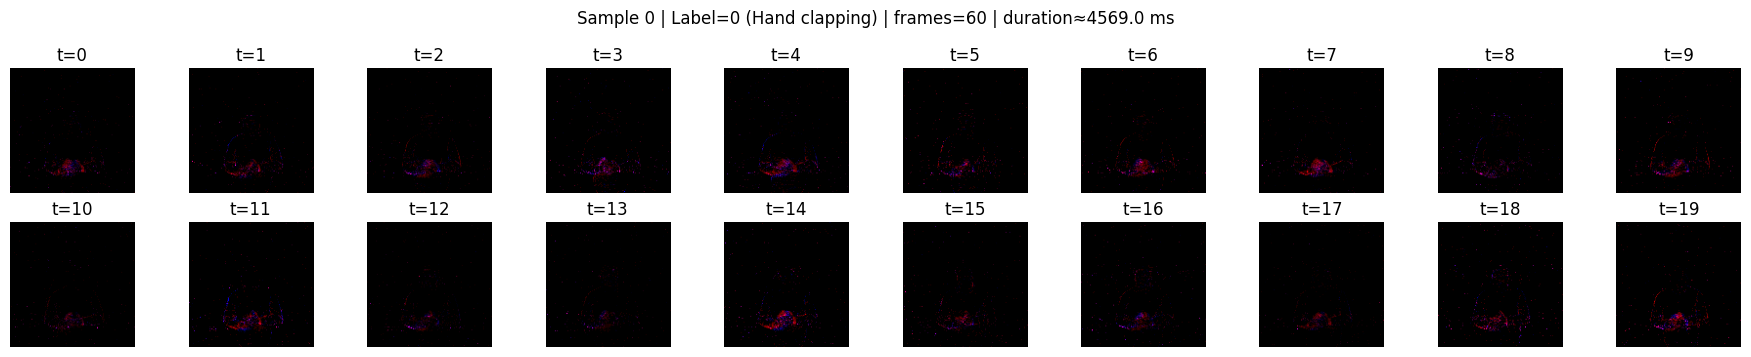

Saved GIF -> ./gifs\test_idx0_label0_Hand clapping.gif
Sample 1 | Label=1 (Right hand wave) | frames=60 | duration≈5995.7 ms


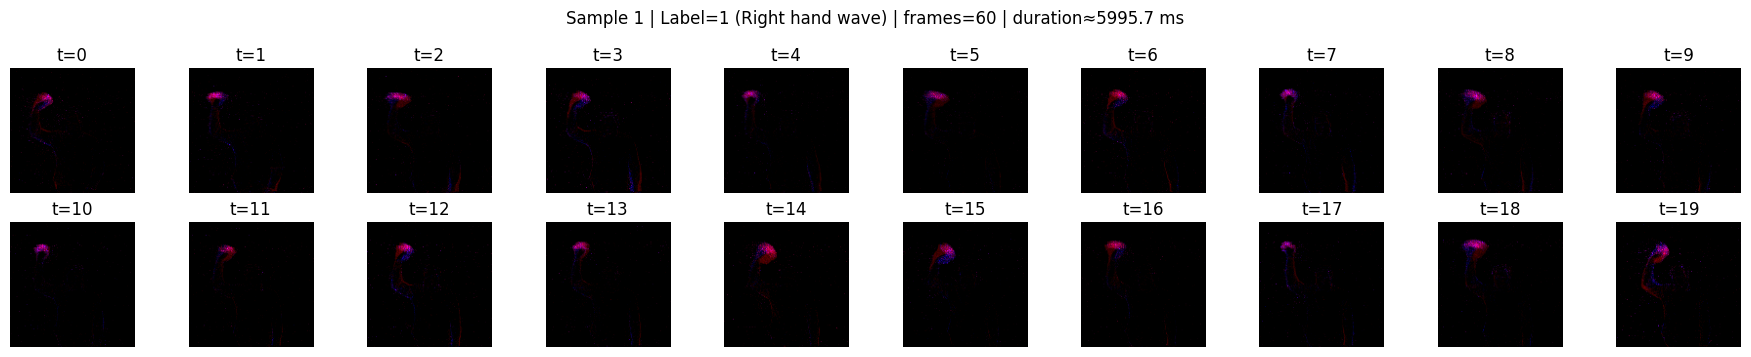

Saved GIF -> ./gifs\test_idx1_label1_Right hand wave.gif
Sample 3 | Label=2 (Left hand wave) | frames=60 | duration≈5437.3 ms


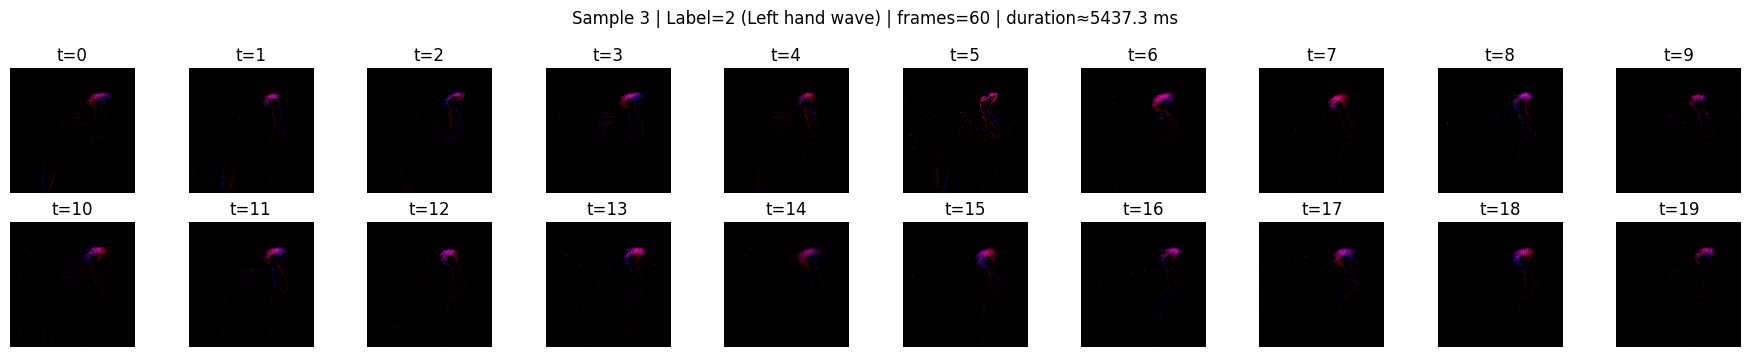

Saved GIF -> ./gifs\test_idx3_label2_Left hand wave.gif
Sample 4 | Label=3 (Right arm cw) | frames=60 | duration≈6772.4 ms


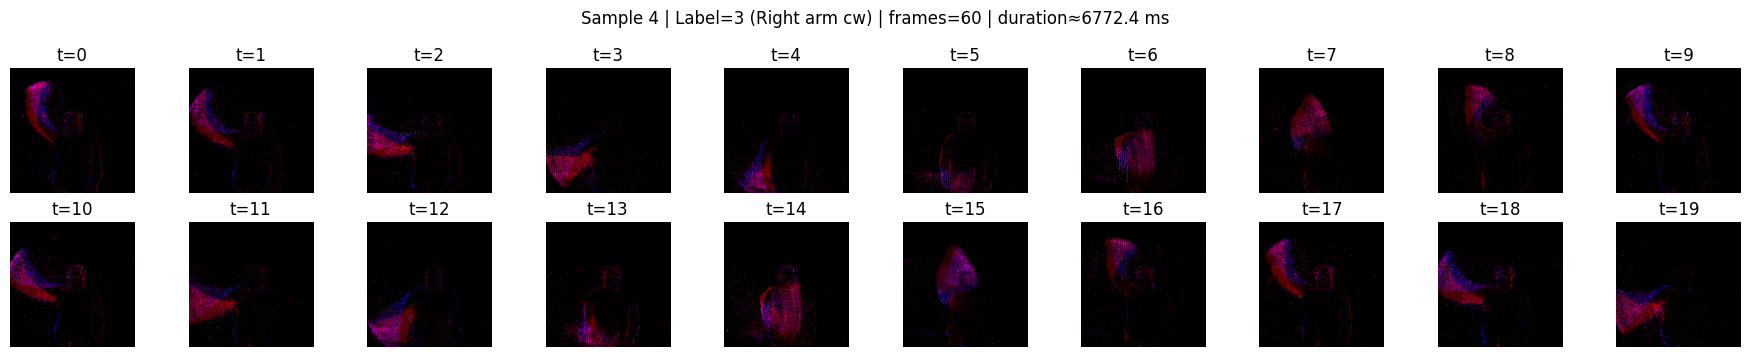

Saved GIF -> ./gifs\test_idx4_label3_Right arm cw.gif
Sample 5 | Label=4 (Right arm ccw) | frames=60 | duration≈5794.6 ms


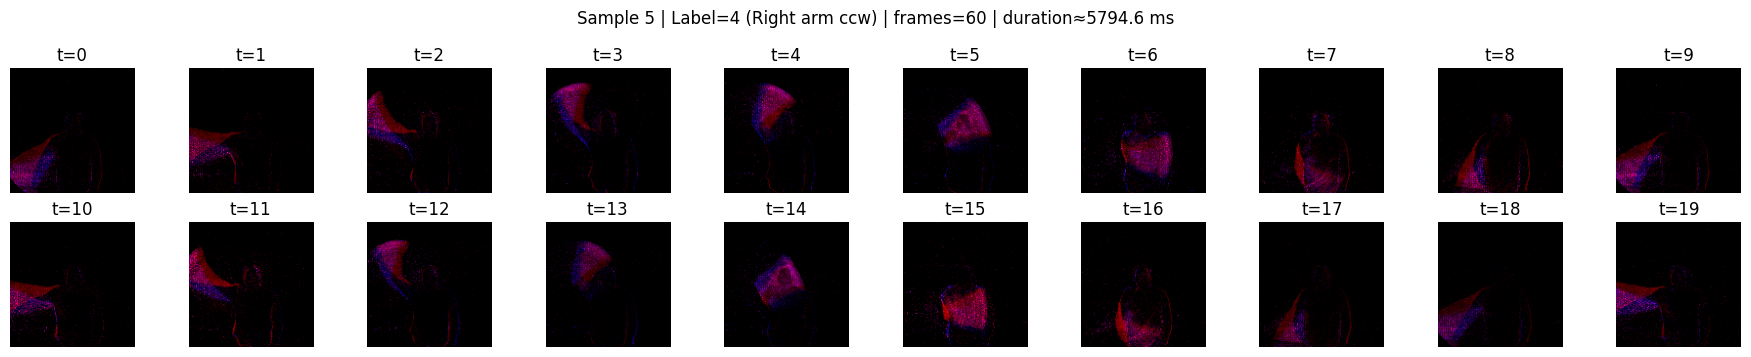

Saved GIF -> ./gifs\test_idx5_label4_Right arm ccw.gif
Sample 6 | Label=5 (Left arm cw) | frames=60 | duration≈5628.6 ms


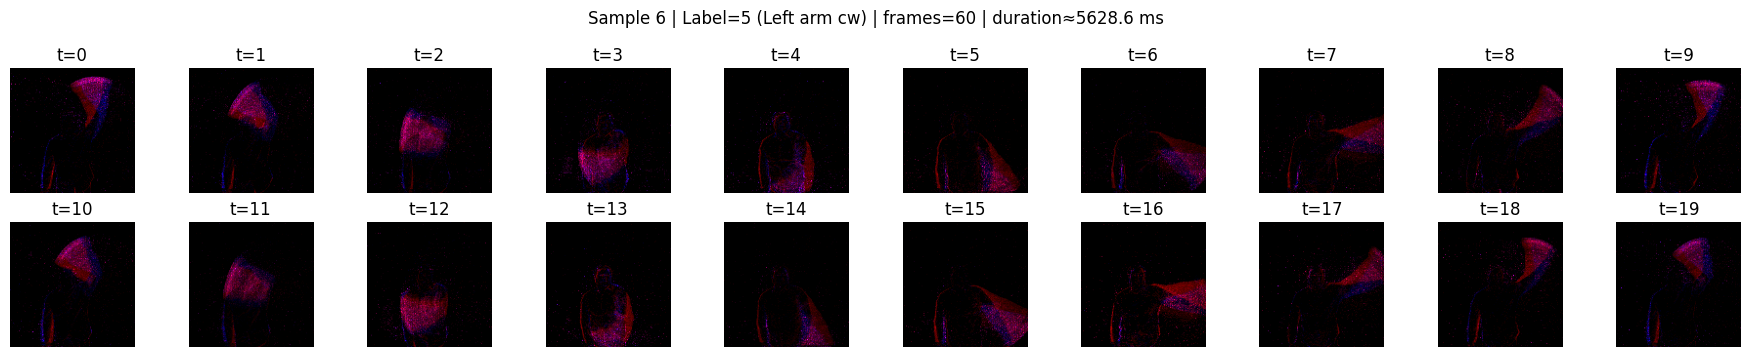

Saved GIF -> ./gifs\test_idx6_label5_Left arm cw.gif
Sample 7 | Label=6 (Left arm ccw) | frames=60 | duration≈6554.0 ms


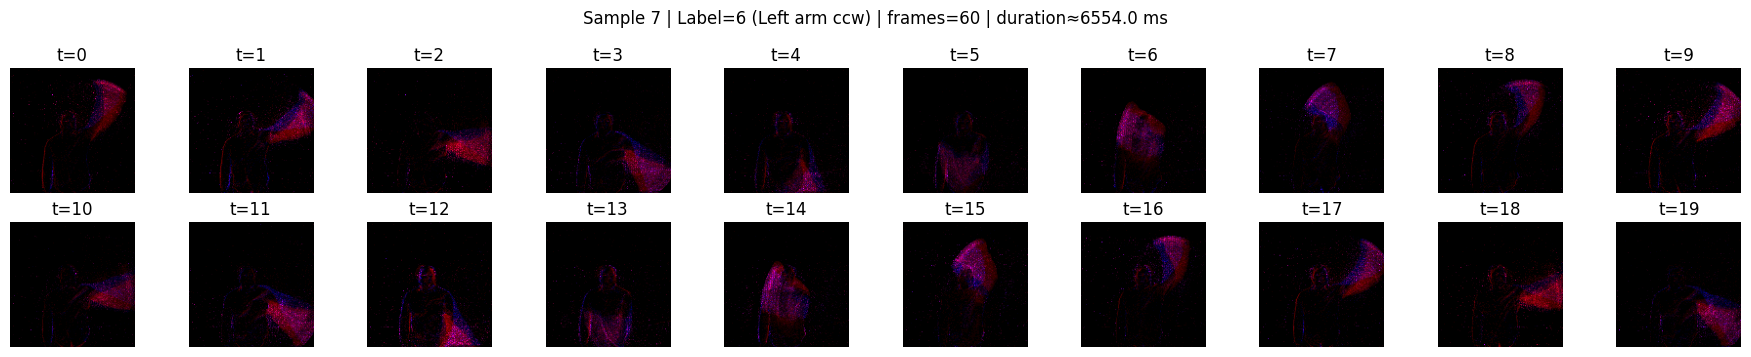

Saved GIF -> ./gifs\test_idx7_label6_Left arm ccw.gif
Sample 8 | Label=7 (Arm roll) | frames=60 | duration≈5528.4 ms


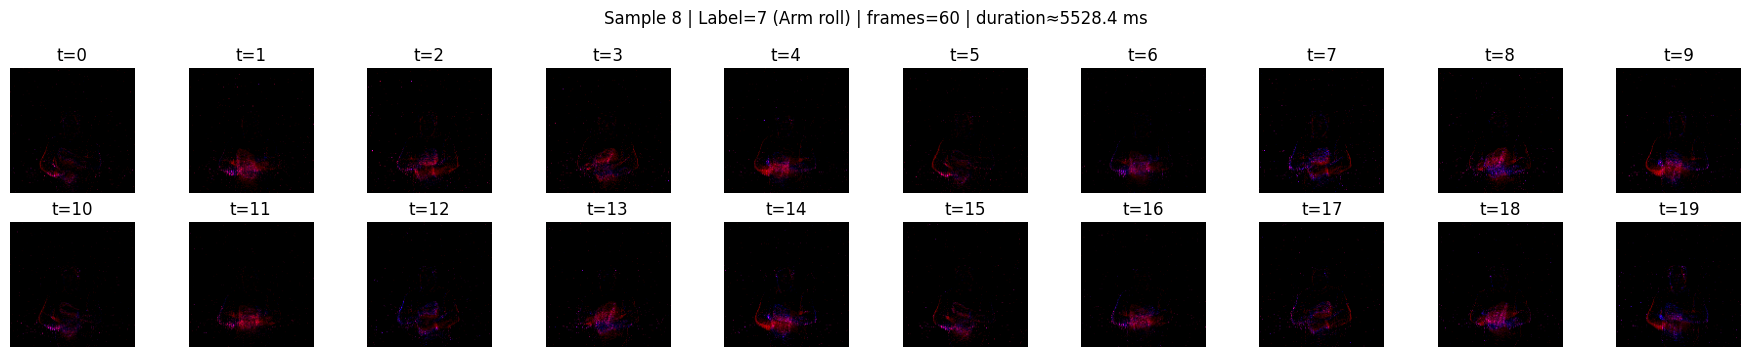

Saved GIF -> ./gifs\test_idx8_label7_Arm roll.gif
Sample 9 | Label=8 (Air drums) | frames=60 | duration≈10000.8 ms


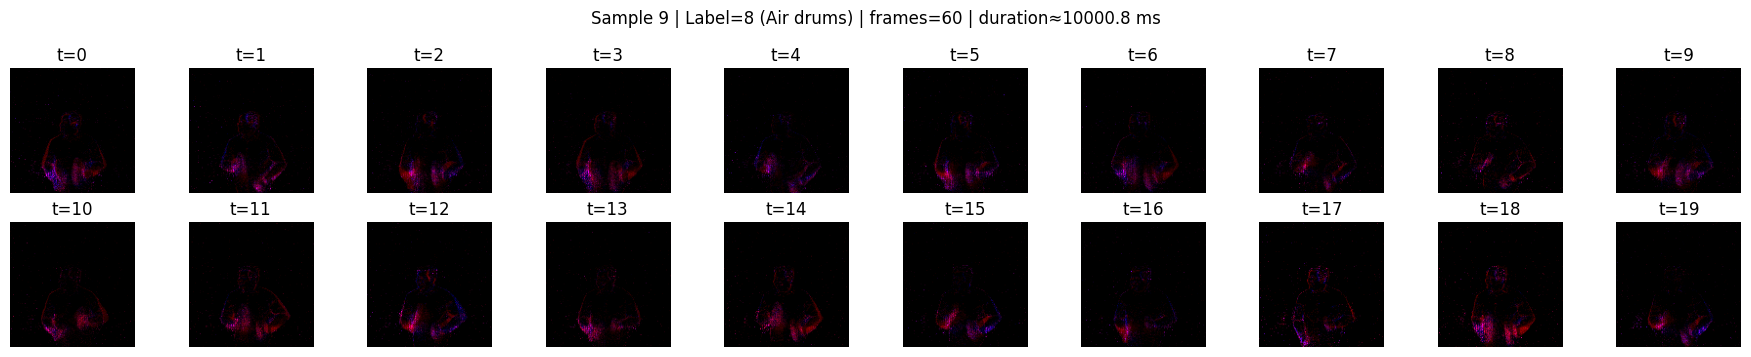

Saved GIF -> ./gifs\test_idx9_label8_Air drums.gif
Sample 10 | Label=9 (Air guitar) | frames=60 | duration≈11208.5 ms


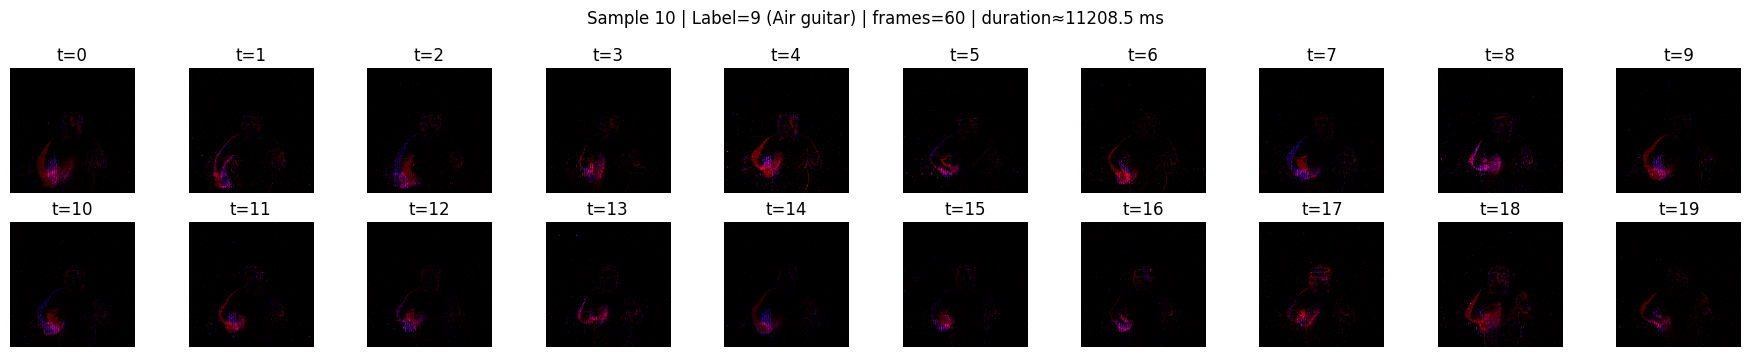

Saved GIF -> ./gifs\test_idx10_label9_Air guitar.gif
Sample 2 | Label=10 (Other gestures) | frames=60 | duration≈8326.0 ms


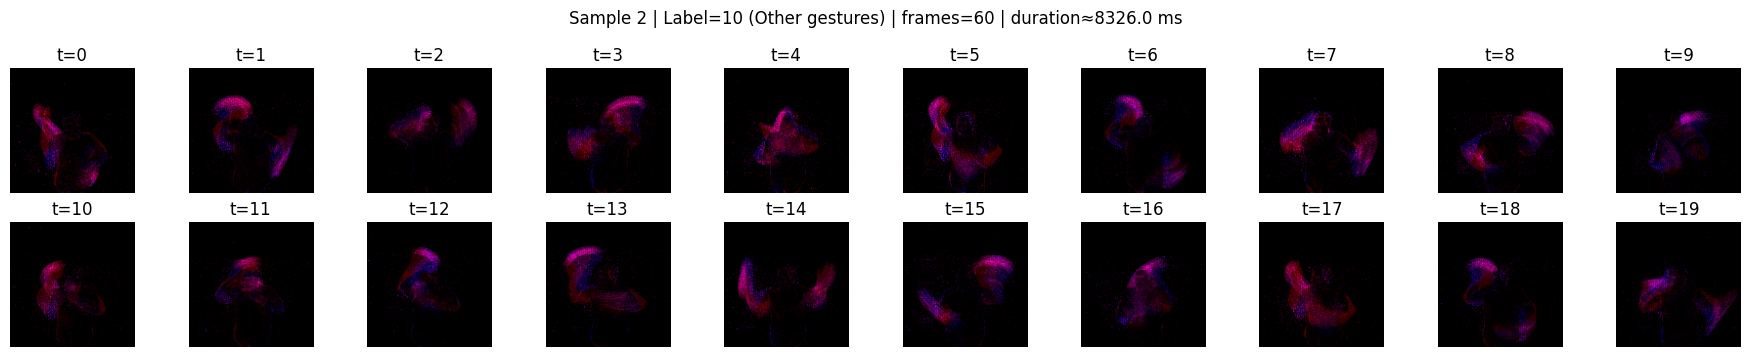

Saved GIF -> ./gifs\test_idx2_label10_Other gestures.gif


In [8]:
from collections import defaultdict

# Build map: label -> first index
first_index_by_label = {}
for i in range(len(test_ds)):
    _, y = test_ds[i]
    if y not in first_index_by_label:
        first_index_by_label[y] = i
    if len(first_index_by_label) >= len(class_names):
        break

print("One example index per label:")
for y in sorted(first_index_by_label.keys()):
    print(f"  label {y:2d} -> idx {first_index_by_label[y]:4d} ({class_names[y]})")

# Preview & save a GIF for each gesture
for y in sorted(first_index_by_label.keys()):
    idx = first_index_by_label[y]
    preview_sample(idx, mode="overlay")
    animate_sample(idx, mode="overlay", save_gif=True, out_dir="./gifs")